In [1]:
import numpy as np
import pandas as pd
import pickle
import random
import joypy

import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
os.chdir(current_wd)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
dataset_folder = project_folder_path + 'results\\synthetic\\dataset\\'
results_folder = project_folder_path + 'results\\synthetic\\results\\fixed_params_var_trials\\'
fig_folder = project_folder_path + 'results\\synthetic\\fig_drafts_paper\\'

In [3]:
save_fig = False

### Load data

In [5]:
with open(dataset_folder + '0_trial_var_tau100ms_alpha0_3_fr3_5hz_len600sec_1000_dict.pkl', 'rb') as f:
    dataset = pickle.load(f)
# trial_dict = trial_dict_full['trial_dict']

n_trials_all = dataset['n_trials']
trial_lens_all = dataset['trial_lens']

In [6]:
with open(results_folder + 'pearsonr_trial_avg_50ms_dict.pkl', "rb") as f:
    pearsonr_trial_avg_dict = pickle.load(f)

with open(results_folder + 'sttc_trial_avg_50ms_dict.pkl', "rb") as f:
    sttc_trial_avg_dict = pickle.load(f)

with open(results_folder + 'sttc_trial_concat_50ms_dict.pkl', "rb") as f:
    sttc_trial_concat_dict = pickle.load(f)

print(f'len pearsonr_trial_avg_dict {len(pearsonr_trial_avg_dict)}')
print(f'len sttc_trial_avg_dict {len(sttc_trial_avg_dict)}')
print(f'len sttc_trial_concat_dict {len(sttc_trial_concat_dict)}')

len pearsonr_trial_avg_dict 1000
len sttc_trial_avg_dict 1000
len sttc_trial_concat_dict 1000


### Make summary dfs

In [ ]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags+1)]
print('acf_cols {}'.format(acf_cols))

In [7]:
def calculate_acf_decline_flag(acf_, start_idx=1, end_idx=4):
    acf_decay = np.all(np.diff(acf_[start_idx:end_idx]) <= 0)
    return acf_decay

In [8]:
def get_trials_plot_df(trial_dict_, method_, n_iteration_=None):
    records = []
    for unit_id, data in trial_dict_.items():
        taus = data['taus']
        acfs = data['acf']

        if n_iteration_ is not None:
            # only one trial per unit
            idx = n_iteration_[unit_id]
            taus_to_iter = [(taus[idx], acfs[idx])]
        else:
            # all trials for this unit
            taus_to_iter = zip(taus, acfs)

        for tau_dict, acf_array in taus_to_iter:
            records.append({
                'unit_id': unit_id,
                'tau': tau_dict['tau'],
                'fit_r_squared': tau_dict['fit_r_squared'],
                'decline_150_250': calculate_acf_decline_flag(acf_array, start_idx=2, end_idx=4),
                'method': method_,
            })

    df = pd.DataFrame.from_records(records)
    df['tau_ms'] = df['tau'] * 50

    nan_count = df.isna().any(axis=1).sum()
    if nan_count > 0:
        print(f'N rows with NaNs {nan_count}')

    return df

In [9]:
gen_random_trials_ids = False
if gen_random_trials_ids:
    n_trials_impl = 50
    random_trials_impl_l = []
    for i in range(n_trials_impl):
        random_trials_impl_l.append(random.choices(range(0, 100), k=1000))
    
    with open(results_folder + 'random_trials_impl_50.pkl', "wb") as f:
        pickle.dump(random_trials_impl_l, f)
else:
    with open(results_folder + 'random_trials_impl_50.pkl', "rb") as f:
        random_trials_impl_l = pickle.load(f)

### Plots

In [28]:
# color_acf_full = '#4783B4'
# color_isttc_full = '#E2552A'
color_pearson_trail_avg = '#6A5ACD' 
color_sttc_trail_avg =  '#FF7F50' 
color_sttc_trail_concat = '#C71585' 

In [ ]:
def plot_one_threshold(axes_, percent_long_df):
    axes_.plot(
    percent_long_df.query('method == "pearsonr_trial_avg"')['interval'],
    percent_long_df.query('method == "pearsonr_trial_avg"')['percentage'],
    color=color_pearson_trail_avg, marker='o', markersize=5, linewidth=0.5, label='pearsonr_avg' 
    )
    axes_.plot(
    percent_long_df.query('method == "sttc_trial_avg"')['interval'],
    percent_long_df.query('method == "sttc_trial_avg"')['percentage'],
    color=color_sttc_trail_avg, marker='o', markersize=5, linewidth=0.5, label='sttc_avg' 
    )
    axes_.plot(
    percent_long_df.query('method == "sttc_trial_concat"')['interval'],
    percent_long_df.query('method == "sttc_trial_concat"')['percentage'],
    color=color_sttc_trail_concat, marker='o', markersize=5, linewidth=0.5, label='sttc_concat' 
    )

def plot_one_threshold_jittered_lines(ax, df, jitter=0.15, seed=None, plot_lines=False):
    if seed is not None:
        np.random.seed(seed)

    methods = [
        ("pearsonr_trial_avg", color_pearson_trail_avg, "pearsonr_avg"),
        ("sttc_trial_avg",     color_sttc_trail_avg,     "sttc_avg"),
        ("sttc_trial_concat",  color_sttc_trail_concat,  "sttc_concat"),
    ]

    # fixed ordering of intervals
    cats = list(df["interval"].unique())
    idx_map = {cat:i for i,cat in enumerate(cats)}

    for method, col, label in methods:
        sub = df[df["method"] == method]
        # map string-labels to integer indices
        x0 = np.array([idx_map[s] for s in sub["interval"]])
        y  = sub["percentage"].values

        #  one jitter per point
        offsets = np.random.uniform(-jitter, jitter, size=len(x0))
        xj = x0 + offsets

        if plot_lines:
            order = np.argsort(x0)
            ax.plot(xj[order], y[order],
                    color=col,
                    linewidth=0.8,
                    alpha=1)
        # plot jittered points
        ax.scatter(xj, y,
                   color=col,
                   s=40,
                   marker="o",
                   label=label)

    ax.set_xticks(np.arange(len(cats)))
    ax.set_xticklabels(cats)

In [ ]:
# intervals for error plots
intervals = {
    '+-100':   (0,   200),
    '+-75':  (25,  175),
    '+-50':  (50,  150),
    '+-25':  (75,  125),
}

### Plots

(for trial based measures one realization of trials is taken)

In [10]:
# df for example plot (for trial based measures one realization of trials is taken)
random_trials_impl = random_trials_impl_l[10]

pearsontr_trial_avg_plot_df = get_trials_plot_df(pearsonr_trial_avg_dict, 'pearsonr_trial_avg', random_trials_impl)
pearsontr_trial_avg_plot_df['n_trials'] = n_trials_all
pearsontr_trial_avg_plot_df['trial_len_ms'] = trial_lens_all
pearsontr_trial_avg_plot_df['tau_ms_true'] = 100
pearsontr_trial_avg_plot_df['tau_diff_abs'] = np.abs(pearsontr_trial_avg_plot_df['tau_ms'] - pearsontr_trial_avg_plot_df['tau_ms_true'])
pearsontr_trial_avg_plot_df['tau_diff_rel'] = pearsontr_trial_avg_plot_df['tau_diff_abs'] / pearsontr_trial_avg_plot_df['tau_ms_true'] * 100

sttc_trial_concat_plot_df = get_trials_plot_df(sttc_trial_concat_dict, 'sttc_trial_concat', random_trials_impl)
sttc_trial_concat_plot_df['n_trials'] = n_trials_all
sttc_trial_concat_plot_df['trial_len_ms'] = trial_lens_all
sttc_trial_concat_plot_df['tau_ms_true'] = 100
sttc_trial_concat_plot_df['tau_diff_abs'] = np.abs(sttc_trial_concat_plot_df['tau_ms'] - sttc_trial_concat_plot_df['tau_ms_true'])
sttc_trial_concat_plot_df['tau_diff_rel'] = sttc_trial_concat_plot_df['tau_diff_abs'] / sttc_trial_concat_plot_df['tau_ms_true'] * 100

sttc_trial_avg_plot_df = get_trials_plot_df(sttc_trial_avg_dict, 'sttc_trial_avg', random_trials_impl)
sttc_trial_avg_plot_df['n_trials'] = n_trials_all
sttc_trial_avg_plot_df['trial_len_ms'] = trial_lens_all
sttc_trial_avg_plot_df['tau_ms_true'] = 100
sttc_trial_avg_plot_df['tau_diff_abs'] = np.abs(sttc_trial_avg_plot_df['tau_ms'] - sttc_trial_avg_plot_df['tau_ms_true'])
sttc_trial_avg_plot_df['tau_diff_rel'] = sttc_trial_avg_plot_df['tau_diff_abs'] / sttc_trial_avg_plot_df['tau_ms_true'] * 100

tau_plot_long_df = pd.concat([pearsontr_trial_avg_plot_df, 
                              sttc_trial_concat_plot_df, 
                              sttc_trial_avg_plot_df])
tau_plot_long_df['log_tau_ms'] = np.log10(tau_plot_long_df['tau_ms'])
tau_plot_long_df.reset_index(inplace=True, drop=True)

tau_plot_long_df

N rows with NaNs 36


,unit_id,tau,fit_r_squared,decline_150_250,method,tau_ms,n_trials,trial_len_ms,tau_ms_true,tau_diff_abs,tau_diff_rel,log_tau_ms
0,0,1.036563,0.095812,False,pearsonr_trial_avg,5.182817e+01,18,4500,100,4.817183e+01,4.817183e+01,1.714566
1,1,2.415129,0.224127,True,pearsonr_trial_avg,1.207564e+02,80,4000,100,2.075644e+01,2.075644e+01,2.081910
2,2,2.730532,0.207617,True,pearsonr_trial_avg,1.365266e+02,69,3500,100,3.652662e+01,3.652662e+01,2.135217
3,3,2.390360,0.139791,True,pearsonr_trial_avg,1.195180e+02,49,4500,100,1.951798e+01,1.951798e+01,2.077433
4,4,3.412505,0.166438,False,pearsonr_trial_avg,1.706253e+02,49,1500,100,7.062525e+01,7.062525e+01,2.232043
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,995,31305.206127,0.644781,False,sttc_trial_avg,1.565260e+06,66,1000,100,1.565160e+06,1.565160e+06,6.194587
2996,996,2.511526,0.271629,True,sttc_trial_avg,1.255763e+02,57,3000,100,2.557631e+01,2.557631e+01,2.098908
2997,997,2.647172,0.129539,True,sttc_trial_avg,1.323586e+02,42,5000,100,3.235860e+01,3.235860e+01,2.121752
2998,998,4.051029,0.266851,True,sttc_trial_avg,2.025514e+02,97,2000,100,1.025514e+02,1.025514e+02,2.306535


In [20]:
# check for NaNs and for a long df remove rows with NaNs (if for a unit one method failed than remove it)

rows_with_nans_pearsonr_df = pearsontr_trial_avg_plot_df[pearsontr_trial_avg_plot_df.isna().any(axis=1)]
n_rows_with_nan_pearsonr = len(rows_with_nans_pearsonr_df)
print(f'N rows with NaNs {n_rows_with_nan_pearsonr}')

rows_with_nans_isttc_concat_df = sttc_trial_concat_plot_df[sttc_trial_concat_plot_df.isna().any(axis=1)]
n_rows_with_nan_isttc_concat = len(rows_with_nans_isttc_concat_df)
print(f'N rows with NaNs {n_rows_with_nan_isttc_concat}')

rows_with_nans_isttc_avg_df = sttc_trial_avg_plot_df[sttc_trial_avg_plot_df.isna().any(axis=1)]
n_rows_with_nan_isttc_avg = len(rows_with_nans_isttc_avg_df)
print(f'N rows with NaNs {n_rows_with_nan_isttc_avg}')

pearsonr_nan_unit_ids = rows_with_nans_pearsonr_df['unit_id'].values
sttc_concat_nan_unit_ids = rows_with_nans_isttc_concat_df['unit_id'].values
sttc_avg_nan_unit_ids = rows_with_nans_isttc_avg_df['unit_id'].values

unit_ids_nan_union = set(pearsonr_nan_unit_ids).union(sttc_concat_nan_unit_ids).union(sttc_avg_nan_unit_ids)
print(f'N rows in unit_ids_nan_union {len(unit_ids_nan_union)}')

# take rows without NaNs
pearsonr_sans_nans_plot_df = pearsontr_trial_avg_plot_df[~pearsontr_trial_avg_plot_df['unit_id'].isin(unit_ids_nan_union)]
sttc_concat_sans_nans_plot_df = sttc_trial_concat_plot_df[~sttc_trial_concat_plot_df['unit_id'].isin(unit_ids_nan_union)]
sttc_avg_sans_nans_plot_df = sttc_trial_avg_plot_df[~sttc_trial_avg_plot_df['unit_id'].isin(unit_ids_nan_union)]

print(f'len pearsonr {len(pearsonr_sans_nans_plot_df)}, len sttc_concat {len(sttc_concat_sans_nans_plot_df)}, len sttc_avg {len(sttc_avg_sans_nans_plot_df)}')

N rows with NaNs 36
N rows with NaNs 0
N rows with NaNs 0
N rows in unit_ids_nan_union 36
len pearsonr 964, len sttc_concat 964, len sttc_avg 964


In [36]:
# check for negative R-square

rows_with_negr_pearsonr_df = pearsonr_sans_nans_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_pearsonr = len(rows_with_negr_pearsonr_df)
print(f'N rows with neg R {n_rows_with_negr_pearsonr}')

rows_with_negr_isttc_concat_df = sttc_concat_sans_nans_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_isttc_concat = len(rows_with_negr_isttc_concat_df)
print(f'N rows with neg R {n_rows_with_negr_isttc_concat}')

rows_with_negr_isttc_avg_df = sttc_avg_sans_nans_plot_df.query('fit_r_squared < 0')
n_rows_with_negr_isttc_avg = len(rows_with_negr_isttc_avg_df)
print(f'N rows with neg R {n_rows_with_negr_isttc_avg}')

pearsonr_negr_unit_ids = rows_with_negr_pearsonr_df['unit_id'].values
isttc_concat_negr_unit_ids = rows_with_negr_isttc_concat_df['unit_id'].values
isttc_avg_negr_unit_ids = rows_with_negr_isttc_avg_df['unit_id'].values

unit_ids_negr_union = set(pearsonr_negr_unit_ids).union(isttc_concat_negr_unit_ids).union(isttc_avg_negr_unit_ids)
print(f'N rows in unit_ids_negr_union {len(unit_ids_negr_union)}, : {unit_ids_negr_union}')

pearsonr_sans_negr_plot_df = pearsonr_sans_nans_plot_df[~pearsonr_sans_nans_plot_df['unit_id'].isin(unit_ids_negr_union)].copy()
sttc_concat_sans_negr_plot_df = sttc_concat_sans_nans_plot_df[~sttc_concat_sans_nans_plot_df['unit_id'].isin(unit_ids_negr_union)].copy()
sttc_avg_sans_negr_plot_df = sttc_avg_sans_nans_plot_df[~sttc_avg_sans_nans_plot_df['unit_id'].isin(unit_ids_negr_union)].copy()

pearsonr_sans_negr_plot_df['tau_diff_rel_log10'] = np.log10(pearsonr_sans_negr_plot_df['tau_diff_rel'])
sttc_concat_sans_negr_plot_df['tau_diff_rel_log10'] = np.log10(sttc_concat_sans_negr_plot_df['tau_diff_rel'])
sttc_avg_sans_negr_plot_df['tau_diff_rel_log10'] = np.log10(sttc_avg_sans_negr_plot_df['tau_diff_rel'])

print(f'len pearsonr {len(pearsonr_sans_negr_plot_df)}, len sttc_concat {len(sttc_concat_sans_negr_plot_df)}, len sttc_avg {len(sttc_avg_sans_negr_plot_df)}')

N rows with neg R 4
N rows with neg R 2
N rows with neg R 2
N rows in unit_ids_negr_union 6, : {np.int64(720), np.int64(945), np.int64(561), np.int64(293), np.int64(428), np.int64(782)}
len pearsonr 958, len sttc_concat 958, len sttc_avg 958


In [37]:
tau_plot_long_df = pd.concat([pearsonr_sans_negr_plot_df, 
                              sttc_concat_sans_negr_plot_df, 
                              sttc_avg_sans_negr_plot_df])
tau_plot_long_df.reset_index(inplace=True, drop=True)

print(f'len tau_plot_long_df {len(tau_plot_long_df)}')

tau_plot_long_df.head(3)

len tau_plot_long_df 2874


,unit_id,tau,fit_r_squared,decline_150_250,method,tau_ms,n_trials,trial_len_ms,tau_ms_true,tau_diff_abs,tau_diff_rel,tau_diff_rel_log10
0,0,1.036563,0.095812,False,pearsonr_trial_avg,51.828168,18,4500,100,48.171832,48.171832,1.682793
1,1,2.415129,0.224127,True,pearsonr_trial_avg,120.756440,80,4000,100,20.756440,20.756440,1.317153
2,2,2.730532,0.207617,True,pearsonr_trial_avg,136.526622,69,3500,100,36.526622,36.526622,1.562610


In [46]:
# Generate n_trials bins 10-100
values = np.linspace(10, 100, num=10).astype(int)
edges_int = np.round(values).astype(int)
# interval labels for df column
labels = [f"n_trials_{edges_int[i]}_{edges_int[i+1]}" for i in range(len(edges_int)-1)]
print(labels)

tau_plot_long_df['n_trials_group'] = pd.cut(
    tau_plot_long_df['n_trials'],
    bins=edges_int,
    labels=labels,
    right=False  # intervals are [left, right)
)

['n_trials_10_20', 'n_trials_20_30', 'n_trials_30_40', 'n_trials_40_50', 'n_trials_50_60', 'n_trials_60_70', 'n_trials_70_80', 'n_trials_80_90', 'n_trials_90_100']


In [47]:
tau_plot_long_df.head(3)

,unit_id,tau,fit_r_squared,decline_150_250,method,tau_ms,n_trials,trial_len_ms,tau_ms_true,tau_diff_abs,tau_diff_rel,tau_diff_rel_log10,n_trials_group
0,0,1.036563,0.095812,False,pearsonr_trial_avg,51.828168,18,4500,100,48.171832,48.171832,1.682793,n_trials_10_20
1,1,2.415129,0.224127,True,pearsonr_trial_avg,120.756440,80,4000,100,20.756440,20.756440,1.317153,n_trials_80_90
2,2,2.730532,0.207617,True,pearsonr_trial_avg,136.526622,69,3500,100,36.526622,36.526622,1.562610,n_trials_60_70


In [ ]:
# tau_plot_wide_df = acf_full_plot_df.merge(isttc_full_plot_df, suffixes=('_acf', '_isttc'), 
#                                           on=['unit_id','fr', 'alpha', 'tau_ms_true', 'duration_ms', 'duration_s', 'dur_interval'], 
#                                           how='left')
# tau_plot_wide_df.reset_index(inplace=True, drop=True)

# print(f'len tau_plot_wide_df {len(tau_plot_wide_df)}')

# tau_plot_wide_df.columns

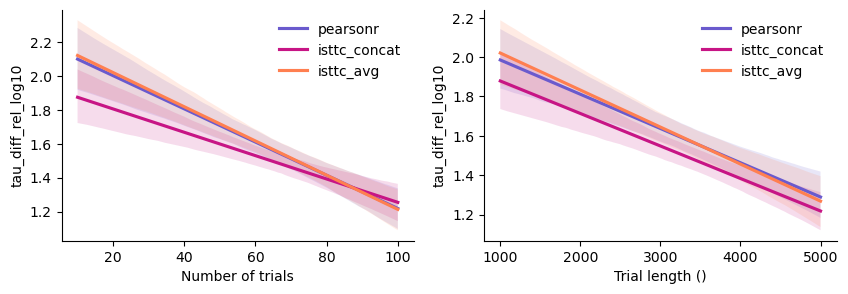

In [38]:
# just to check, I plot the same as predicted values from the model
fig, axes = plt.subplots(1,2, figsize=(10, 3), sharey=False)

sns.regplot(x='n_trials', y='tau_diff_rel_log10', data=tau_plot_long_df.query('method == "pearsonr_trial_avg"'),
            scatter=None, ax=axes[0], 
            label='pearsonr', color=color_pearson_trail_avg)
sns.regplot(x='n_trials', y='tau_diff_rel_log10', data=tau_plot_long_df.query('method == "sttc_trial_concat"'),
            scatter=None, ax=axes[0], 
            label='isttc_concat', color=color_sttc_trail_concat)
sns.regplot(x='n_trials', y='tau_diff_rel_log10', data=tau_plot_long_df.query('method == "sttc_trial_avg"'),
            scatter=None, ax=axes[0], 
            label='isttc_avg', color=color_sttc_trail_avg)
axes[0].legend(frameon=False)
axes[0].set_xlabel('Number of trials')

sns.regplot(x='trial_len_ms', y='tau_diff_rel_log10', data=tau_plot_long_df.query('method == "pearsonr_trial_avg"'),
            scatter=None, ax=axes[1], 
            label='pearsonr', color=color_pearson_trail_avg)
sns.regplot(x='trial_len_ms', y='tau_diff_rel_log10', data=tau_plot_long_df.query('method == "sttc_trial_concat"'),
            scatter=None, ax=axes[1], 
            label='isttc_concat', color=color_sttc_trail_concat)
sns.regplot(x='trial_len_ms', y='tau_diff_rel_log10', data=tau_plot_long_df.query('method == "sttc_trial_avg"'),
            scatter=None, ax=axes[1], 
            label='isttc_avg', color=color_sttc_trail_avg)
axes[1].legend(frameon=False)
axes[1].set_xlabel('Trial length ()')

# for ax in axes.flat:
#     ax.set_ylabel('Log10 diff(IT, \nground truth) (ms)')

sns.despine()

In [48]:
# intervals for error plots
intervals = {
    '+-100':   (0,   200),
    '+-75':  (25,  175),
    '+-50':  (50,  150),
    '+-25':  (75,  125),
}

df = tau_plot_long_df.copy()
rows = []
for method, sub in df.groupby(by=['method','n_trials_group', 'trial_len_ms']):
    total = len(sub)
    row = {'method': method}
    for name, (lo, hi) in intervals.items():
        cnt = sub['tau_ms'].between(lo, hi).sum()
        row[name] = cnt/total*100
    rows.append(row)
tau_2methods_error_df = pd.DataFrame(rows).set_index('method')

# # make long df
# tau_2methods_error_df = tau_2methods_error_df.reset_index()
# tau_2methods_error_long_df = tau_2methods_error_df.melt(
#     id_vars='method',
#     var_name='interval',
#     value_name='percentage'
# )

# tau_2methods_error_long_df[['method','dur_interval']] = pd.DataFrame(
#     tau_2methods_error_long_df['method'].tolist(),
#     index=tau_2methods_error_long_df.index
# )
# tau_2methods_error_long_df = tau_2methods_error_long_df.rename(columns={'interval':'error_interval'})
# tau_2methods_error_long_df = tau_2methods_error_long_df[['method','dur_interval','error_interval','percentage']]

C:\Users\ipochino\AppData\Local\Temp\ipykernel_17456\2398529946.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for method, sub in df.groupby(by=['method','n_trials_group', 'trial_len_ms']):


ValueError: Columns must be same length as key

In [49]:
tau_2methods_error_df

,method,+-100,+-75,+-50,+-25
0,"(pearsonr_trial_avg, n_trials_10_20, 1000)",83.333333,50.000000,50.000000,33.333333
1,"(pearsonr_trial_avg, n_trials_10_20, 1500)",100.000000,57.142857,42.857143,14.285714
2,"(pearsonr_trial_avg, n_trials_10_20, 2000)",62.500000,25.000000,12.500000,0.000000
3,"(pearsonr_trial_avg, n_trials_10_20, 2500)",88.888889,55.555556,44.444444,33.333333
4,"(pearsonr_trial_avg, n_trials_10_20, 3000)",77.777778,77.777778,44.444444,22.222222
...,...,...,...,...,...
238,"(sttc_trial_concat, n_trials_90_100, 3000)",100.000000,90.909091,81.818182,72.727273
239,"(sttc_trial_concat, n_trials_90_100, 3500)",83.333333,83.333333,83.333333,50.000000
240,"(sttc_trial_concat, n_trials_90_100, 4000)",100.000000,100.000000,90.909091,54.545455
241,"(sttc_trial_concat, n_trials_90_100, 4500)",100.000000,92.307692,92.307692,76.923077


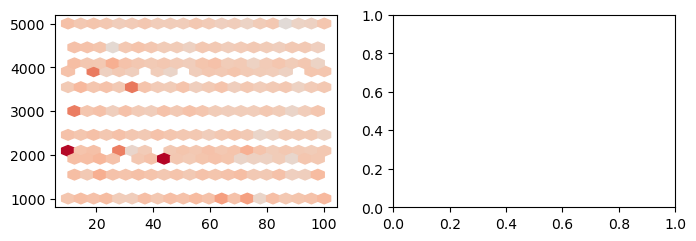

In [39]:
fig, axes = plt.subplots(1,2, figsize=(8,2.5))

norm = TwoSlopeNorm(vcenter=0)

hb0 = axes[0].hexbin(
    x=pearsonr_sans_negr_plot_df['n_trials'], y=pearsonr_sans_negr_plot_df['trial_len_ms'],
    C=pearsonr_sans_negr_plot_df['tau_diff_rel_log10'],
    reduce_C_function=np.median,   
    gridsize=20,                
    cmap='coolwarm',
    norm = norm,
    mincnt=1                    
)


In [ ]:
df = tau_5methods_one_trial_impl_df.copy()

rows = []
for method, sub in df.groupby('method'):
    total = len(sub)
    row = {'method': method}
    for name, (lo, hi) in intervals.items():
        cnt = sub['tau_ms'].between(lo, hi).sum()
        row[name] = cnt/total*100
    rows.append(row)

tau_5methods_one_trial_impl_error_df = pd.DataFrame(rows).set_index('method')

# make long df
tau_5methods_one_trial_impl_error_df = tau_5methods_one_trial_impl_error_df.reset_index()
tau_5methods_one_trial_impl_error_long_df = tau_5methods_one_trial_impl_error_df.melt(
    id_vars='method',
    var_name='interval',
    value_name='percentage'
)
tau_5methods_one_trial_impl_error_long_df

In [ ]:
# get percentage of units with tau?ms in 200ms range
mask = tau_5methods_one_trial_impl_df['tau_ms'].between(0, 200)
tau_5methods_one_trial_impl_0_200ms_df = (
    tau_5methods_one_trial_impl_df
    .groupby('method')
    .agg(
        total       = ('tau_ms', 'size'),
        in_range    = ('tau_ms', lambda x: x.between(0,200).sum())
    )
)
tau_5methods_one_trial_impl_0_200ms_df['percent_in_range'] = tau_5methods_one_trial_impl_0_200ms_df['in_range'] / tau_5methods_one_trial_impl_0_200ms_df['total'] * 100
tau_5methods_one_trial_impl_0_200ms_df = tau_5methods_one_trial_impl_0_200ms_df.assign(
    percent_in_range=lambda d: d['percent_in_range'].map("{:.1f}%".format)
)
tau_5methods_one_trial_impl_0_200ms_df

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plot_one_threshold(axes[0], tau_5methods_one_trial_impl_error_long_df)

plot_one_threshold_jittered_lines(axes[1],
    tau_5methods_one_trial_impl_error_long_df,
    jitter=0.3, seed=42)

plot_one_threshold_jittered_lines(axes[2],
    tau_5methods_one_trial_impl_error_long_df,
    jitter=0.2, seed=42, plot_lines=True)

for ax in axes.flat:
    ax.set_ylabel('Percentage of \nspike trains')
    ax.set_xlabel('Error (ms)')
    ax.set_ylim([0, 105])
    ax.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
    sns.despine(ax=ax)
    
axes[0].legend(frameon=False)


if save_fig:
    plt.savefig(fig_folder + 'taus_error_one_trials_impl.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_error_one_trials_impl.svg' , bbox_inches='tight')

#### Supp for Example plot for panel B

(for trial based measures 50 realization of trials are taken, error is median across 50 realizations)

In [ ]:
dfs = []

for idx, random_trials_impl in enumerate(random_trials_impl_l):
    # method’s df for this particular impl
    df_p = get_trials_plot_df(pearsonr_trial_avg_dict,
                              'pearsonr_trial_avg',
                              random_trials_impl)
    df_sa = get_trials_plot_df(sttc_trial_avg_dict,
                               'sttc_trial_avg',
                               random_trials_impl)
    df_sc = get_trials_plot_df(sttc_trial_concat_dict,
                               'sttc_trial_concat',
                               random_trials_impl)
    df_full = acf_full_plot_df.copy()
    df_isttc = acf_isttc_full_plot_df.copy()
    
    one_ex = pd.concat([df_full,
                        df_isttc,
                        df_p,
                        df_sa,
                        df_sc],
                       ignore_index=True)
    
    one_ex['log_tau_ms'] = np.log10(one_ex['tau_ms'])
    one_ex['random_trials_impl_idx'] = idx
    
    dfs.append(one_ex)

tau_5methods_50_trial_impl_df = pd.concat(dfs, ignore_index=True)

# sanity check
print(tau_5methods_50_trial_impl_df.shape)
print(tau_5methods_50_trial_impl_df['random_trials_impl_idx'].nunique(), 'unique impls')

In [ ]:
tau_5methods_50_trial_impl_df

In [ ]:
df = tau_5methods_50_trial_impl_df.copy()

rows = []
for idx, df_idx in df.groupby('random_trials_impl_idx'):
    total_idx = len(df_idx)
    for method, df_m in df_idx.groupby('method'):
        total_m = len(df_m)
        for name, (lo, hi) in intervals.items():
            cnt = df_m['tau_ms'].between(lo, hi).sum()
            rows.append({
                'random_trials_impl_idx': idx,
                'method': method,
                'interval': name,
                'percentage': cnt/total_m * 100
            })

tau_5methods_50_trial_impl_error_long_df = pd.DataFrame(rows)
tau_5methods_50_trial_impl_error_long_df

In [ ]:
tau_5methods_50_trial_impl_error_long_avg_df = (
    tau_5methods_50_trial_impl_error_long_df
    .groupby(['method','interval'])['percentage']
    .agg(
        median = 'median',
        lower_95 = lambda x: x.quantile(0.025),
        upper_95 = lambda x: x.quantile(0.975)
    )
    .reset_index()
)
tau_5methods_50_trial_impl_error_long_avg_df = tau_5methods_50_trial_impl_error_long_avg_df.rename(columns={'median': 'percentage'})
order = ['+-100', '+-75', '+-50', '+-25']
tau_5methods_50_trial_impl_error_long_avg_df['interval'] = pd.Categorical(
    tau_5methods_50_trial_impl_error_long_avg_df['interval'],
    categories=order,
    ordered=True
)
tau_5methods_50_trial_impl_error_long_avg_df.sort_values('interval', inplace=True)
tau_5methods_50_trial_impl_error_long_avg_df

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plot_one_threshold(axes[0], tau_5methods_50_trial_impl_error_long_avg_df)

plot_one_threshold_jittered_lines(axes[1],
    tau_5methods_50_trial_impl_error_long_avg_df,
    jitter=0.3, seed=42)

plot_one_threshold_jittered_lines(axes[2],
    tau_5methods_50_trial_impl_error_long_avg_df,
    jitter=0.2, seed=42, plot_lines=True)

for ax in axes.flat:
    ax.set_ylabel('Percentage of \nspike trains')
    ax.set_xlabel('Error (ms)')
    ax.set_ylim([0, 105])
    ax.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
    sns.despine(ax=ax)
    
axes[0].legend(frameon=False)

if save_fig:
    plt.savefig(fig_folder + 'taus_error_50_trials_impl.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_error_50_trials_impl.svg' , bbox_inches='tight')

#### For Panel D - error when 100 trial realizations are used to estimate tau

In [ ]:
acf_pearsontr_trial_avg_df = get_trials_plot_df(pearsonr_trial_avg_dict, 'pearsonr_trial_avg')
acf_sttc_trial_concat_df = get_trials_plot_df(sttc_trial_concat_dict, 'sttc_trial_concat')
acf_sttc_trial_avg_df = get_trials_plot_df(sttc_trial_avg_dict, 'sttc_trial_avg')

acf_pearsontr_trial_avg_df_med = acf_pearsontr_trial_avg_df.groupby(by=['unit_id', 'method'], as_index=False)['tau_ms'].median()
acf_sttc_trial_concat_df_med = acf_sttc_trial_concat_df.groupby(by=['unit_id', 'method'], as_index=False)['tau_ms'].median()
acf_sttc_trial_avg_df_med = acf_sttc_trial_avg_df.groupby(by=['unit_id', 'method'], as_index=False)['tau_ms'].median()

tau_concat_avg_df = pd.concat([acf_full_plot_df, acf_isttc_full_plot_df, 
                           acf_pearsontr_trial_avg_df_med, 
                               acf_sttc_trial_concat_df_med, 
                               acf_sttc_trial_avg_df_med])
tau_concat_avg_df['log_tau_ms'] = np.log10(tau_concat_avg_df['tau_ms'])
tau_concat_avg_df.reset_index(inplace=True, drop=True)
tau_concat_avg_df

In [ ]:
tau_concat_df = pd.concat([acf_full_plot_df, acf_isttc_full_plot_df, 
                           acf_pearsontr_trial_avg_df, 
                               acf_sttc_trial_concat_df, 
                               acf_sttc_trial_avg_df])
tau_concat_df['log_tau_ms'] = np.log10(tau_concat_df['tau_ms'])
tau_concat_df.reset_index(inplace=True, drop=True)
tau_concat_df

tau_concat_df.to_pickle(results_folder + 'tau_concat_df.pkl')

In [ ]:
df = tau_concat_avg_df.copy()

rows = []
for method, sub in df.groupby('method'):
    total = len(sub)
    row = {'method': method}
    for name, (lo, hi) in intervals.items():
        cnt = sub['tau_ms'].between(lo, hi).sum()
        row[name] = cnt/total*100
    rows.append(row)

tau_5methods_100_trial_impl_avg_error_df = pd.DataFrame(rows).set_index('method')

tau_5methods_100_trial_impl_avg_error_df = tau_5methods_100_trial_impl_avg_error_df.reset_index()
tau_5methods_100_trial_impl_avg_error_long_df = tau_5methods_100_trial_impl_avg_error_df.melt(
    id_vars='method',
    var_name='interval',
    value_name='percentage'
)
tau_5methods_100_trial_impl_avg_error_long_df

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plot_one_threshold(axes[0], tau_5methods_100_trial_impl_avg_error_long_df)

plot_one_threshold_jittered_lines(axes[1],
    tau_5methods_100_trial_impl_avg_error_long_df,
    jitter=0.3, seed=42)

plot_one_threshold_jittered_lines(axes[2],
    tau_5methods_100_trial_impl_avg_error_long_df,
    jitter=0.2, seed=42, plot_lines=True)

for ax in axes.flat:
    ax.set_ylabel('Percentage of \nspike trains')
    ax.set_xlabel('Error (ms)')
    ax.set_ylim([0, 105])
    ax.grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)
    sns.despine(ax=ax)

axes[0].legend(frameon=False)

if save_fig:
    plt.savefig(fig_folder + 'taus_error_med_100_trials_impl.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'taus_error_med_100_trials_impl.svg' , bbox_inches='tight')

In [ ]:
tau_concat_avg_df.describe()

In [ ]:
fig, axes = joypy.joyplot(data=tau_concat_avg_df,
    by='method',
    column='tau_ms',
    range_style='own',
    grid="y",
    kind='kde',
    overlap=2,
    alpha=0.5,
    linewidth=1,
    x_range=[1, 250]
)

axes[-1].axvline(x=100, color='k', lw=0.5)

axes[-1].set_xlabel('Log10 Intrinsic timescale')
fig.suptitle('1000ms trials (n=40) x 100 realizations vs full signal, \ntau = 100ms', y=1.05)

# if save_fig:
#     plt.savefig(fig_folder + '100ms_5_methods_100_trial_impl_log.png' , bbox_inches='tight', dpi=300)
#     plt.savefig(fig_folder + '100ms_5_methods_100_trial_impl_log.svg' , bbox_inches='tight')

In [ ]:
# get percentage of units with tau?ms in 200ms range
mask = tau_concat_avg_df['tau_ms'].between(0, 200)
tau_concat_avg_0_200ms_df = (
    tau_concat_avg_df
    .groupby('method')
    .agg(
        total       = ('tau_ms', 'size'),
        in_range    = ('tau_ms', lambda x: x.between(0,200).sum())
    )
)
tau_concat_avg_0_200ms_df['percent_in_range'] = tau_concat_avg_0_200ms_df['in_range'] / tau_concat_avg_0_200ms_df['total'] * 100
tau_concat_avg_0_200ms_df = tau_concat_avg_0_200ms_df.assign(
    percent_in_range=lambda d: d['percent_in_range'].map("{:.1f}%".format)
)
tau_concat_avg_0_200ms_df

In [ ]:
fig, axes = joypy.joyplot(data=tau_concat_avg_df.query('tau_ms > 0 and tau_ms <= 200'),
    by='method',
    column='tau_ms',
    range_style='own',
    grid="y",
    #kind='kde',
    hist=True, bins=100, fill=False,
    overlap=0.1,
    alpha=0.5,
    linewidth=1,
    x_range=[0, 200]
)

axes[-1].axvline(x=100, color='k', lw=0.5)

axes[-1].set_xlabel('Log10 Intrinsic timescale')
fig.suptitle('1000ms trials (n=40) x 100 realizations vs full signal, \ntau = 100ms', y=1.05)

method_order = [
    'acf_full',
    'isttc_full',
    'pearsonr_trial_avg',
    'sttc_trial_avg',
    'sttc_trial_concat',
]
for ax, method in zip(axes, method_order):
    tot    = tau_concat_avg_0_200ms_df.at[method, 'total']
    inn    = tau_concat_avg_0_200ms_df.at[method, 'in_range']
    pct    = tau_concat_avg_0_200ms_df.at[method, 'percent_in_range']
    txt    = f"{inn}/{tot} ({pct})"
    # place in axis‐relative coords (x=95% from left, y=center)
    ax.text(
        0.95, 0.5, txt,
        transform = ax.transAxes,
        ha        = 'right',
        va        = 'center',
        fontsize  = 10,
        alpha     = 0.8
    )

if save_fig:
    plt.savefig(fig_folder + '100ms_5_methods_100_trial_impl_hist.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + '100ms_5_methods_100_trial_impl_hist.svg' , bbox_inches='tight')